# 3) Points Scored - Linear Regression

Predicting the exact score for a team is difficult, but I wanted to see how close the model could get.

In [1]:
#Imports
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
#Reading in the csv where the DataFrame was stored
df = pd.read_csv(r'nfl_game_logs_df.csv', index_col=0)

In [3]:
#Some quick exploration on how many points each team scored
df['points_for'].describe().to_frame()

,points_for
count,5994.000000
mean,22.836003
std,10.084374
min,0.000000
25%,16.000000
50%,23.000000
75%,30.000000
max,70.000000


Points in American football are, generally speaking, scored seven or three at a time. This means that certain totals are far more likely than others, even if they are only a point different in either direction.

In [4]:
points_scored = df['points_for'].value_counts().sort_index().to_frame()
points_scored = points_scored.reindex(list(range(points_scored.index.min(), points_scored.index.max() + 1)), fill_value=0)
points_scored.index.name = 'points_scored'
points_scored.rename(columns={'points_for': 'count'}, inplace=True)
points_scored['freq_percent'] = points_scored['count'] / points_scored['count'].sum() * 100



points_scored.sort_values(by='count', ascending=False).head(10)

,count,freq_percent
points_scored,,
20,411,6.856857
17,404,6.740073
24,389,6.489823
27,368,6.139473
23,296,4.938272
10,266,4.437771
31,260,4.337671
13,247,4.120787
16,242,4.037371


In [5]:
points_scored.head(20)

,count,freq_percent
points_scored,,
0,62,1.034368
1,0,0.000000
2,1,0.016683
3,107,1.785118
4,0,0.000000
5,3,0.050050
6,105,1.751752
7,124,2.068735
8,8,0.133467


These are the point totals that did not appear in the data set. Small totals like one and four are extremely rare in American football because they would require very rare scoring plays and nothing else for the team the rest of the game. As point values increase, there are more combinations of scoring plays that would sum to that total. Totals of 60-69 did not appear simply because they are less than the data set's maximum of 70, a clear outlier.

In [6]:
points_scored.query('count == 0')

,count,freq_percent
points_scored,,
1,0,0.0
4,0,0.0
60,0,0.0
61,0,0.0
62,0,0.0
63,0,0.0
64,0,0.0
65,0,0.0
66,0,0.0


This bar chart shows the frequencies of differnt point totals. There are many highs and lows in the graph, but we can see a vague bell-curve. Bucketing these totals into five-point ranges would account for the rarer point totals and show more of a normal distribution.

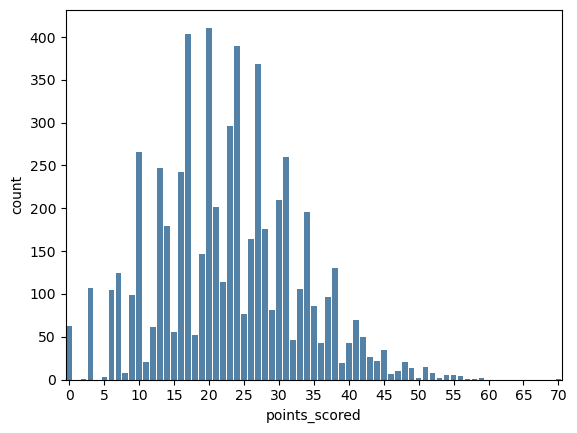

In [7]:
s = sns.barplot(data=points_scored, x=points_scored.index, y='count', color='steelblue');
s.set_xticks(range(0,71,5));

This boxplot of points scored, like the description we saw above, gives a sense of the likely point ranges. However, it's important to remember that certain totals are very rare in American football, even if they are close in value to the median.

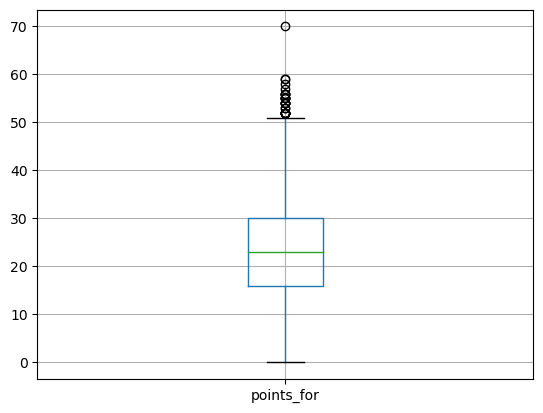

In [8]:
df['points_for'].to_frame().boxplot();

# Linear Model

How accurate would a Linear Model be to predict the number of points a team scores in a game? Could we predict this value for both teams as a way to model the winner of the game?

In [9]:
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df['points_for']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    # Create a NumPy array with the same shape as y_test.
    y_mean = np.zeros_like(y_test, dtype=float)
    y_median = np.zeros_like(y_test, dtype=float)
    y_mode = np.zeros_like(y_test, dtype=float)

    # Fill the array with the mean value of y_test.
    y_mean.fill(y_test.mean())
    print('RMSE for Mean: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_mean))))
    
    y_median.fill(y_test.median())
    print('RMSE for Median: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_median))))
    
    y_mode.fill(y_test.mode())
    print('RMSE for Mode: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_mode))))
    
    
    
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    print('RMSE for ' + str(feature_cols) + ' is \n' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

After running the above train_test_rmse function for a number of statistics, the below list is creates the best linear regression model I could find. This gives us a RMSE of 9.43.

This is better than predicting the mean points scored for every game. I also tested the median and mode since those might be better approximations for a specific score in American football, but the mean works in this case as we are concerned with getting a value close to the points scored, not picking the exact amount. (The mean points scored is 22.8, which works fine for a linear regression. But teams are much more likely to score 20, 21, or 24 points than 22 or 23.

In [10]:
feature_options = ['elo_start',
                    'elo_start_opp',
                    'home_team',
                    'distance_travelled_opp_diff',
                    '7_game_avg_points_for',
                    '7_game_avg_points_allowed',
                    '6_game_avg_tot_yds',
                    '2_game_avg_exp_pts_off',
                    '2_game_avg_exp_pts_def',
                    '7_game_avg_exp_pts_st',
                    '7_game_avg_points_allowed_opp',
                    '7_game_avg_points_for_opp',
                    '6_game_avg_opp_first_downs_opp',
                    '6_game_avg_exp_pts_def_opp']

train_test_rmse(df, feature_options)

RMSE for Mean: 10.16302675937795
RMSE for Median: 10.179509563004277
RMSE for Mode: 11.593659558625461
RMSE for ['elo_start', 'elo_start_opp', 'home_team', 'distance_travelled_opp_diff', '7_game_avg_points_for', '7_game_avg_points_allowed', '6_game_avg_tot_yds', '2_game_avg_exp_pts_off', '2_game_avg_exp_pts_def', '7_game_avg_exp_pts_st', '7_game_avg_points_allowed_opp', '7_game_avg_points_for_opp', '6_game_avg_opp_first_downs_opp', '6_game_avg_exp_pts_def_opp'] is 
9.434421682611026
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [11]:
feature_cols = ['elo_start',
                    'elo_start_opp',
                    'home_team',
                    'distance_travelled_opp_diff',
                    '7_game_avg_points_for',
                    '7_game_avg_points_allowed',
                    '6_game_avg_tot_yds',
                    '2_game_avg_exp_pts_off',
                    '2_game_avg_exp_pts_def',
                    '7_game_avg_exp_pts_st',
                    '7_game_avg_points_allowed_opp',
                    '7_game_avg_points_for_opp',
                    '6_game_avg_opp_first_downs_opp',
                    '6_game_avg_exp_pts_def_opp']

X = df[feature_cols]
y = df['points_for']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [12]:
y_pred = LR.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

9.434421682611026

In [13]:
df['mov_winner'].mean()

11.349683016349683

The RMSE of 9.43 is a bit lower than using the mean for the linear regression. But that would need to be applied to both teams if we want to use it to pick a winner. To put that into context, the average margin of victory in the data set is over 11 points. A linear model that could swing 18 points wouldn't be very useful.